In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt, pi
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [2]:
epochs = 50
device = torch.device("cpu")

eps = 1

learning_rate = 1e-3
batchflag = True
batchsize = 128

start = 0.
end = 1.
x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

def actual_soln(eps):
    p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
    return (np.sin(np.pi*x) + (eps*np.pi/p)*(np.exp(-x/eps) + np.exp((x-1)/eps) - q) ) * (2*y*(1 - y**2) + eps * ( p*d*(1-2*y) - 3*q/p + (3/p - d)*np.exp(-y/eps) + (3/p + d)*np.exp((y-1)/eps)))


In [3]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

def plot_graphs(soln1,soln2,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln1.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class FBPINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(FBPINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()


	def forward(self,x):		
		tanh1 = self.tanh(x)
		tanh2 = self.tanh(1 - x)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		out = x*tanh11*tanh22
		return out

In [4]:

def train(device,net,x,y,eps,learning_rate,epochs,batch_flag,batch_size):

	xnet = torch.Tensor(x)
	ynet = torch.Tensor(y) 
	
	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		#print(len(dataloader))
	
	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		
		p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
		
		soln = (torch.sin(np.pi*xnet) + (eps*np.pi/p)*(torch.exp(-xnet/eps) + torch.exp((xnet-1)/eps) - q) ) * (2*ynet*(1 - ynet*ynet) + eps * ( p*d*(1-2*ynet) - 3*q/p + (3/p - d)*torch.exp(-ynet/eps) + (3/p + d)*torch.exp((ynet-1)/eps)))
		
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)
		
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	losses = [];errors = []
	tic = time.time()

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 150:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 == 0:
					print('Train Epoch: {} \tLoss: {:.20f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			#if epoch % 1 == 0:
				#plot_graph(z,'Predicted solution')
			
			losses.append(loss.item())
			errors.append(actual_loss)
	else:
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			if epoch % 5 == 0:
				plot_graph(z,'Predicted solution')
			losses.append(loss.item())
			errors.append(actual_loss)

	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output,net,losses,errors 

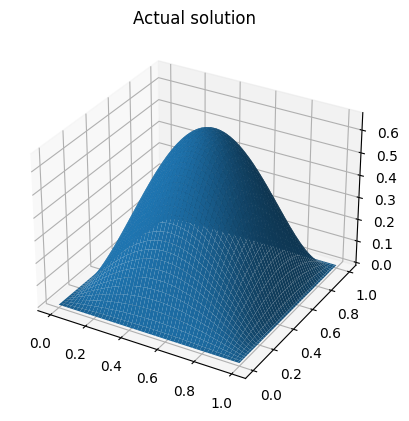

In [5]:
plot_graph(actual_soln(0.02),'Actual solution')



  Epsilon : 0.1


Train Epoch: 0 	Loss: 24.46050834655761718750
Train Epoch: 0 	Loss: 30.95585250854492187500
Train Epoch: 0 	Loss: 20.78996467590332031250
Train Epoch: 0 	Loss: 19.83690071105957031250

After Epoch 0, 	 Actual solution loss: 0.00601733159091616572

Train Epoch: 1 	Loss: 16.83136367797851562500
Train Epoch: 1 	Loss: 15.82803249359130859375
Train Epoch: 1 	Loss: 15.72498130798339843750
Train Epoch: 1 	Loss: 15.94812774658203125000

After Epoch 1, 	 Actual solution loss: 0.00397866841930564954

Train Epoch: 2 	Loss: 11.82178688049316406250
Train Epoch: 2 	Loss: 10.31180381774902343750
Train Epoch: 2 	Loss: 9.26216411590576171875
Train Epoch: 2 	Loss: 5.31849193572998046875

After Epoch 2, 	 Actual solution loss: 0.00065229358176375498

Train Epoch: 3 	Loss: 3.36901021003723144531
Train Epoch: 3 	Loss: 1.09913194179534912109
Train Epoch: 3 	Loss: 0.56053650379180908203
Train Epoch: 3 	Loss: 0.11848657578229904175

After Epoch 3, 	 Actual solution loss: 0.0000008800509107

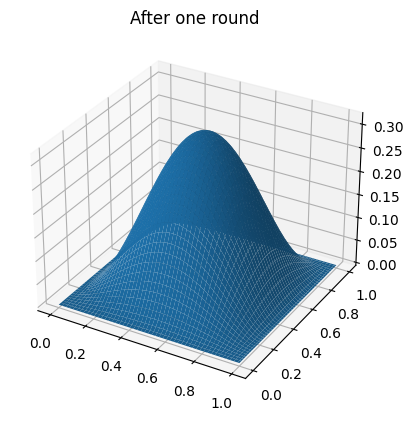

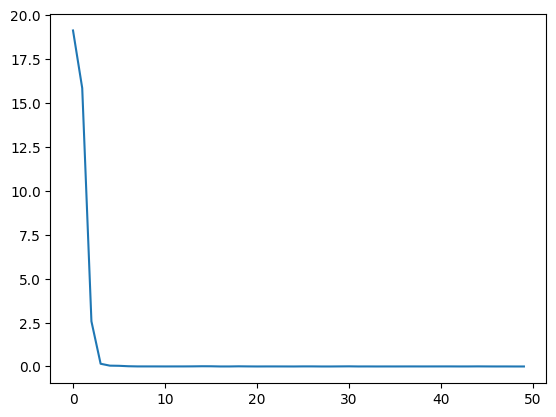



  Epsilon : 0.05


Train Epoch: 0 	Loss: 22.56883621215820312500
Train Epoch: 0 	Loss: 17.78158760070800781250
Train Epoch: 0 	Loss: 15.35582733154296875000
Train Epoch: 0 	Loss: 10.80317211151123046875

After Epoch 0, 	 Actual solution loss: 0.00827526925747214433

Train Epoch: 1 	Loss: 9.60551548004150390625
Train Epoch: 1 	Loss: 7.38002014160156250000
Train Epoch: 1 	Loss: 8.72707462310791015625
Train Epoch: 1 	Loss: 6.67524147033691406250

After Epoch 1, 	 Actual solution loss: 0.00229111313312066770

Train Epoch: 2 	Loss: 4.10177278518676757812
Train Epoch: 2 	Loss: 2.42252635955810546875
Train Epoch: 2 	Loss: 2.79011940956115722656
Train Epoch: 2 	Loss: 4.95331764221191406250

After Epoch 2, 	 Actual solution loss: 0.00010955800382024079

Train Epoch: 3 	Loss: 3.43571114540100097656
Train Epoch: 3 	Loss: 2.87588429450988769531
Train Epoch: 3 	Loss: 3.43398332595825195312
Train Epoch: 3 	Loss: 1.50767946243286132812

After Epoch 3, 	 Actual solution loss: 0.00009416731663262405


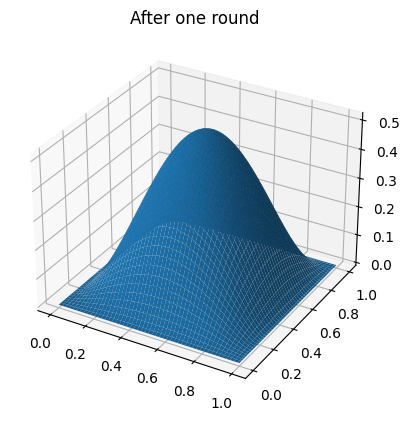

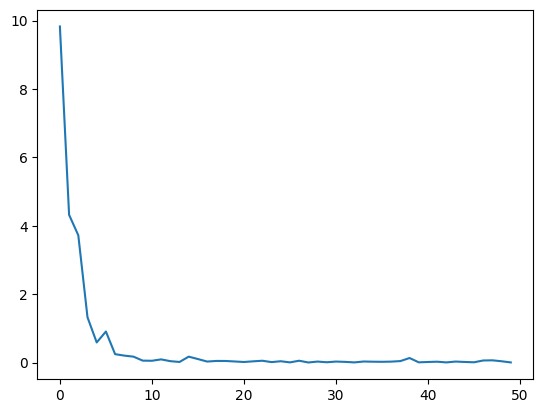



  Epsilon : 0.02


Train Epoch: 0 	Loss: 90.30372619628906250000
Train Epoch: 0 	Loss: 44.32501602172851562500
Train Epoch: 0 	Loss: 49.56722259521484375000
Train Epoch: 0 	Loss: 45.32443237304687500000

After Epoch 0, 	 Actual solution loss: 0.05337268593913992165

Train Epoch: 1 	Loss: 36.94907760620117187500
Train Epoch: 1 	Loss: 36.36083602905273437500
Train Epoch: 1 	Loss: 34.21412658691406250000
Train Epoch: 1 	Loss: 33.14037322998046875000

After Epoch 1, 	 Actual solution loss: 0.03944656164866089387

Train Epoch: 2 	Loss: 35.41878509521484375000
Train Epoch: 2 	Loss: 34.00701904296875000000
Train Epoch: 2 	Loss: 31.10062980651855468750
Train Epoch: 2 	Loss: 28.80244445800781250000

After Epoch 2, 	 Actual solution loss: 0.03790764633502736319

Train Epoch: 3 	Loss: 25.95422554016113281250
Train Epoch: 3 	Loss: 27.26615142822265625000
Train Epoch: 3 	Loss: 24.12517547607421875000
Train Epoch: 3 	Loss: 30.45718002319335937500

After Epoch 3, 	 Actual solution loss: 0.041052682

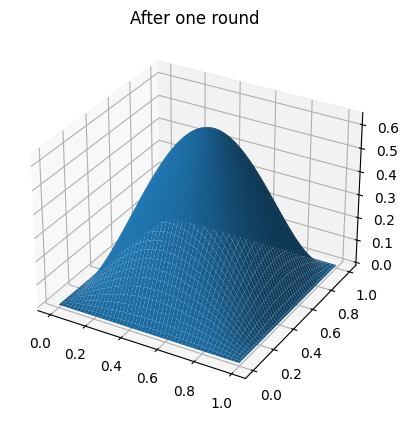

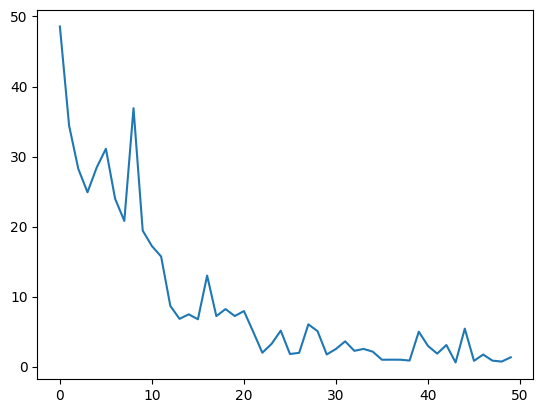



  Epsilon : 0.015


Train Epoch: 0 	Loss: 72.47821044921875000000
Train Epoch: 0 	Loss: 24.72296333312988281250
Train Epoch: 0 	Loss: 13.86784744262695312500
Train Epoch: 0 	Loss: 9.97525787353515625000

After Epoch 0, 	 Actual solution loss: 0.01458441899243707873

Train Epoch: 1 	Loss: 11.41932106018066406250
Train Epoch: 1 	Loss: 9.03890037536621093750
Train Epoch: 1 	Loss: 7.23931074142456054688
Train Epoch: 1 	Loss: 10.50987529754638671875

After Epoch 1, 	 Actual solution loss: 0.00480710567010809303

Train Epoch: 2 	Loss: 4.95075225830078125000
Train Epoch: 2 	Loss: 5.67053651809692382812
Train Epoch: 2 	Loss: 5.83962440490722656250
Train Epoch: 2 	Loss: 5.75638341903686523438

After Epoch 2, 	 Actual solution loss: 0.00579681914107683938

Train Epoch: 3 	Loss: 10.64264202117919921875
Train Epoch: 3 	Loss: 20.86306381225585937500
Train Epoch: 3 	Loss: 26.79271125793457031250
Train Epoch: 3 	Loss: 25.52445220947265625000

After Epoch 3, 	 Actual solution loss: 0.018216079259299

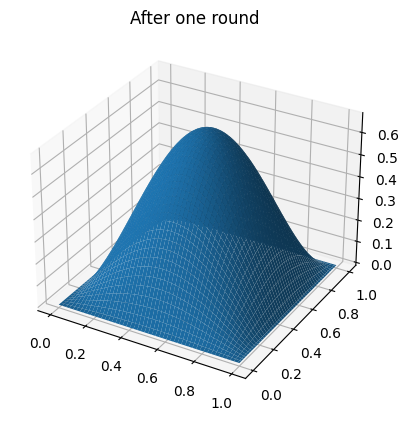

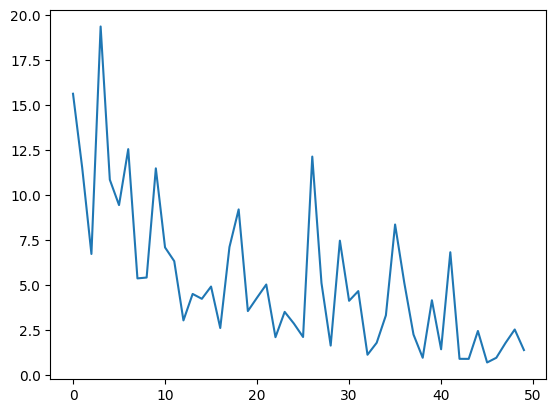



  Epsilon : 0.01


Train Epoch: 0 	Loss: 158.40151977539062500000
Train Epoch: 0 	Loss: 39.01462173461914062500
Train Epoch: 0 	Loss: 41.12303161621093750000
Train Epoch: 0 	Loss: 35.45279693603515625000

After Epoch 0, 	 Actual solution loss: 0.03559200460965868118

Train Epoch: 1 	Loss: 24.60731887817382812500
Train Epoch: 1 	Loss: 30.12883186340332031250
Train Epoch: 1 	Loss: 28.77665901184082031250
Train Epoch: 1 	Loss: 22.92965126037597656250

After Epoch 1, 	 Actual solution loss: 0.02169348932671430127

Train Epoch: 2 	Loss: 26.65152359008789062500
Train Epoch: 2 	Loss: 25.89661598205566406250
Train Epoch: 2 	Loss: 29.71157073974609375000
Train Epoch: 2 	Loss: 24.05717086791992187500

After Epoch 2, 	 Actual solution loss: 0.02816279776729707987

Train Epoch: 3 	Loss: 27.73970603942871093750
Train Epoch: 3 	Loss: 30.82285499572753906250
Train Epoch: 3 	Loss: 19.66235733032226562500
Train Epoch: 3 	Loss: 24.40017700195312500000

After Epoch 3, 	 Actual solution loss: 0.02455221

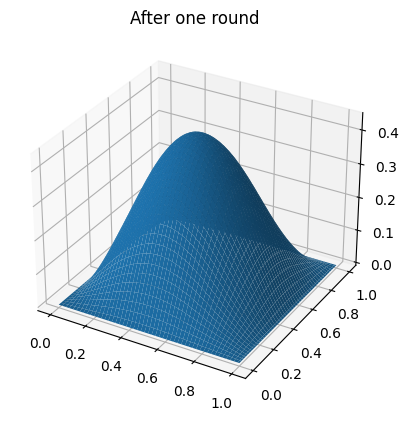

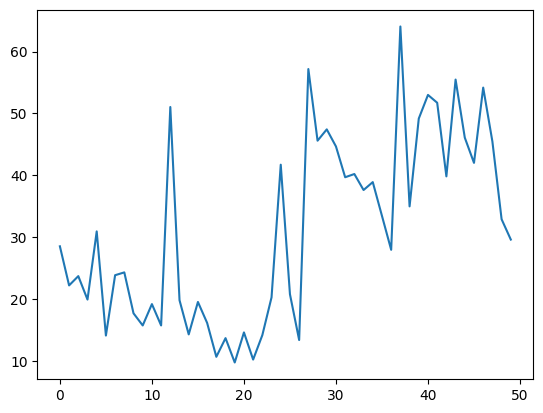

In [6]:
net = FBPINN()#.to(device)
	
def init_normal(m):
	if type(m) == nn.Linear:
		nn.init.kaiming_normal_(m.weight)

net.apply(init_normal)

for eps in [0.1,0.05,0.02,0.015,0.01]:
	print('\n\n  Epsilon : {}\n\n'.format(eps))
	output,net,losses,errors = train(device,net,x,y,eps,learning_rate,epochs,batchflag,batchsize)
	plot_graph(output.detach().numpy(),"After one round")
	plt.plot(losses)
	plt.show()

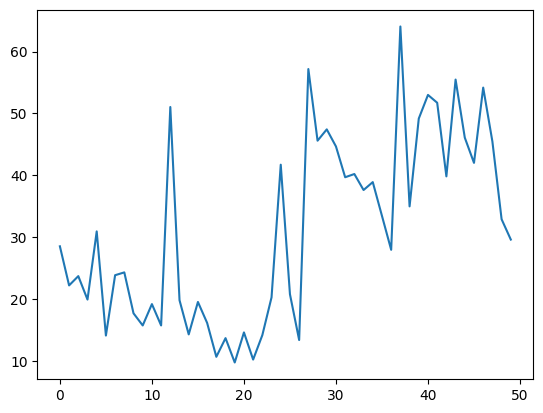

In [7]:
plt.plot(losses)
plt.show()

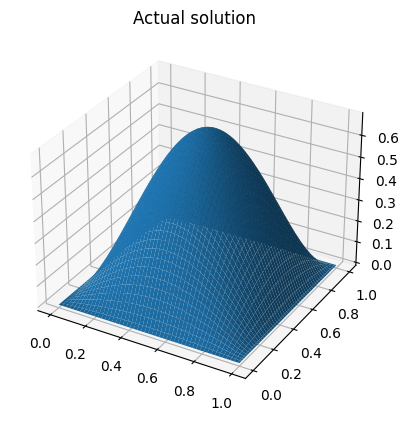

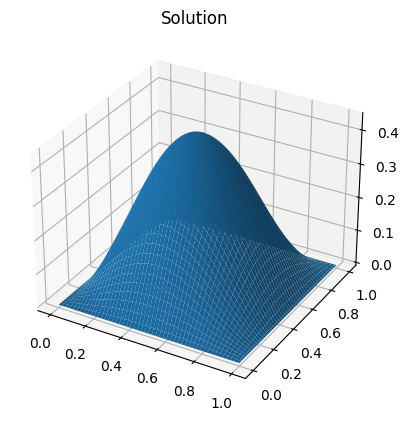

In [10]:
plot_graph(actual_soln(0.015),'Actual solution')
plot_graph(output.detach().numpy(),'Solution')